Kaggle Ames Housing Data Competition - Replacing Missing Values

I start out by importing the usual suspects, and I set the format to 3 decimal points.

In [77]:
import numpy as np
import pandas as pd
import os
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

I will need to calculate some statistics later, so I import them here.

In [78]:
from scipy import stats
from scipy.stats import norm, skew

I will also be using Matplotlib and Seaborn for graphics.

In [79]:
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
import matplotlib.pyplot as plt
%matplotlib inline

Now I import the data and make sure it looks OK.

In [80]:
os.listdir('C:\\Users\\iriley\\Documents\\588-econometrics')

['.git',
 '.ipynb_checkpoints',
 'data_cleaning_example.ipynb',
 'Homework-2.ipynb',
 'Regression Trees Project V2.ipynb',
 'Regression Trees Project.ipynb',
 'replace_missing.ipynb',
 'test.csv',
 'test2.csv',
 'train.csv',
 'train2.csv',
 'v3.ipynb']

In [81]:
train = pd.read_csv('C:\\Users\\iriley\\Documents\\588-econometrics\\train.csv')
test = pd.read_csv('C:\\Users\\iriley\\Documents\\588-econometrics\\test.csv')

In [82]:
print(format(train.shape))
print(format(test.shape))

(1460, 81)
(1459, 80)


I'll want the IDs later, but I don't need them for training, so I'll create column vectors with them and then delete them from the data frame.

In [83]:
print(format(train.shape))
print(format(test.shape))

(1460, 81)
(1459, 80)


In [84]:
train.head

<bound method NDFrame.head of         Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL       65.000     8450   Pave   NaN      Reg   
1        2          20       RL       80.000     9600   Pave   NaN      Reg   
2        3          60       RL       68.000    11250   Pave   NaN      IR1   
3        4          70       RL       60.000     9550   Pave   NaN      IR1   
4        5          60       RL       84.000    14260   Pave   NaN      IR1   
5        6          50       RL       85.000    14115   Pave   NaN      IR1   
6        7          20       RL       75.000    10084   Pave   NaN      Reg   
7        8          60       RL          nan    10382   Pave   NaN      IR1   
8        9          50       RM       51.000     6120   Pave   NaN      Reg   
9       10         190       RL       50.000     7420   Pave   NaN      Reg   
10      11          20       RL       70.000    11200   Pave   NaN      Reg   
11      12          60

I first need to concatenate the train and test data in the same dataframe, so that all the changes I make will apply to both sets.

In [85]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_ = pd.concat((train, test)).reset_index(drop=True)
#all_.drop(['SalePrice'], axis=1, inplace=True)
print("all_ size is : {}".format(all_.shape))

all_ size is : (2919, 81)


### Missing Data

Now I have to do the tedious work of going through and taking care of missing values.

In [86]:
all_na = (all_.isnull().sum() / len(all_)) * 100
all_na = all_na.drop(all_na[all_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Percent Missing' :all_na})
missing_data.head(20)

,Percent Missing
PoolQC,99.657
MiscFeature,96.403
Alley,93.217
Fence,80.439
SalePrice,49.983
FireplaceQu,48.647
LotFrontage,16.650
GarageQual,5.447
GarageCond,5.447
GarageFinish,5.447


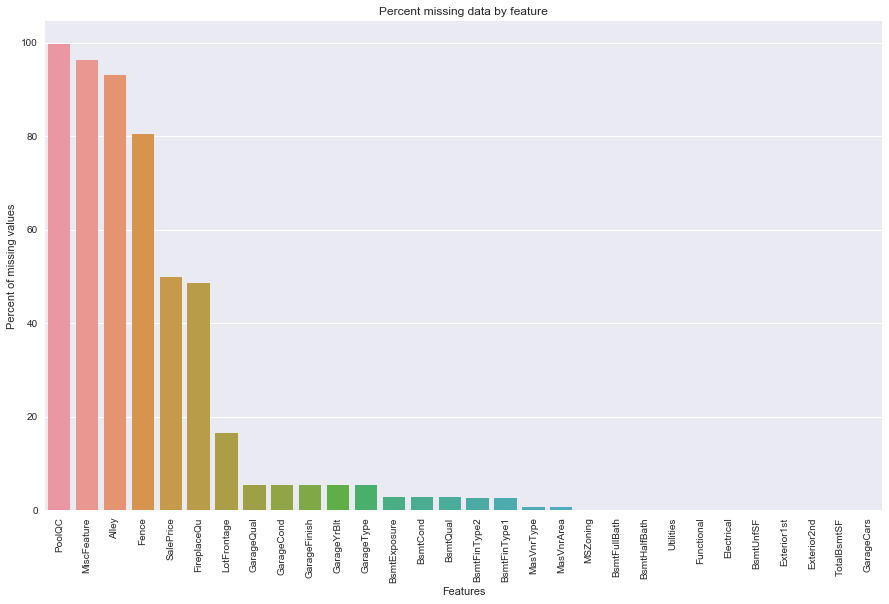

In [87]:
f, ax = plt.subplots(figsize=(15, 9))
plt.xticks(rotation='90')
sns.barplot(x=all_na.index, y=all_na)
plt.xlabel('Features')
plt.ylabel('Percent of missing values')
plt.title('Percent missing data by feature')

### Imputation of Missing Values

We impute them by proceeding sequentially through features with missing values

* PoolQC : data description says NA means "No Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general.

In [88]:
all_["PoolQC"] = all_["PoolQC"].fillna("None")

* MiscFeature: NA = "no misc feature", ok to just replace with "None"

In [89]:
all_["MiscFeature"] = all_["MiscFeature"].fillna("None")

* Alley: NA = "no alley access", so it's trivial to just replace with "None"; similar for fence

In [90]:
all_["Alley"] = all_["Alley"].fillna("None")
all_["Fence"] = all_["Fence"].fillna("None")

* FireplaceQu: NA means "no fireplace", so just replace with "None" again


In [91]:
all_["FireplaceQu"] = all_["FireplaceQu"].fillna("None")

* LotFrontage: This is probably similar to other houses in its neighborhood, so we can fill in missing values by the median LotFrontage of the neighborhood.


In [92]:
all_["LotFrontage"] = all_.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

* GarageType, GarageFinish, GarageQual and GarageCond: Here I am simply replacing missing data with 'None', since that seems like the most likely reason for values of a garage variable to be missing.

In [93]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_[col] = all_[col].fillna('None')

* GarageYrBlt, GarageArea and GarageCars : Here I am just replacing missing data with 0 (Since no garage ==> no cars in such garage.)


In [94]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_[col] = all_[col].fillna(0)

* BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath: since these all have to do with the basement, the missing values are likely zero for having no basement


In [95]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_[col] = all_[col].fillna(0)

* BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : For all these categorical basement-related features, NaN means that there is no basement.


In [96]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_[col] = all_[col].fillna('None')

* MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.


In [97]:
all_["MasVnrType"].value_counts()

None       1742
BrkFace     879
Stone       249
BrkCmn       25
Name: MasVnrType, dtype: int64

"MasVnrArea" is a numeric variable, so NA probably means 0.

In [98]:
all_["MasVnrType"] = all_["MasVnrType"].fillna("None")
all_["MasVnrArea"] = all_["MasVnrArea"].fillna(0)

* MSZoning (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'


In [99]:
all_['MSZoning'] = all_['MSZoning'].fillna(all_['MSZoning'].mode()[0])

* Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA, so mode replacement is probably fine. But this feature doesn't add anything - it has the same values for everything but 1, so I may as well drop it.

In [100]:
all_['Utilities'].describe()

count       2917
unique         2
top       AllPub
freq        2916
Name: Utilities, dtype: object

In [101]:
all_ = all_.drop('Utilities', axis=1)

* Functional has NA meaning "typical", so me may as well rename it.

In [102]:
all_["Functional"] = all_["Functional"].fillna("Typical")

* Electrical has one NA value. Since this feature has mostly 'SBrkr', I can use mode replacement again for the missing value.

In [103]:
all_['Electrical'] = all_['Electrical'].fillna(all_['Electrical'].mode()[0])

* KitchenQual, Exterior1st/2nd: Only one NA value, so once again, I use the mode to replace missing values.

In [104]:
all_['KitchenQual'].value_counts()

TA    1492
Gd    1151
Ex     205
Fa      70
Name: KitchenQual, dtype: int64

In [105]:
all_['Exterior1st'].value_counts()[:5]

VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
Name: Exterior1st, dtype: int64

In [106]:
all_['Exterior2nd'].value_counts()[:5]

VinylSd    1014
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     270
Name: Exterior2nd, dtype: int64

In [107]:
all_['KitchenQual'] = all_['KitchenQual'].fillna(all_['KitchenQual'].mode()[0])
all_['Exterior1st'] = all_['Exterior1st'].fillna(all_['Exterior1st'].mode()[0])
all_['Exterior2nd'] = all_['Exterior2nd'].fillna(all_['Exterior2nd'].mode()[0])

* SaleType: Once again, I can use the mode here. These variables just have relatively few missing values and clear modal values, so I am confident that mode replacement will not hurt the modelling.

In [108]:
all_['SaleType'].value_counts()[:5]

WD       2525
New       239
COD        87
ConLD      26
CWD        12
Name: SaleType, dtype: int64

In [109]:
all_['SaleType'] = all_['SaleType'].fillna(all_['SaleType'].mode()[0])

* MSSubClass: Since Na most likely means "no building class", I can replace missing values with None

In [110]:
all_['MSSubClass'] = all_['MSSubClass'].fillna("None")

Any more missing values?

In [111]:
all__na = (all_.isnull().sum() / len(all_)) * 100
all__na = all__na.drop(all__na[all__na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all__na})
missing_data.head()

,Missing Ratio
SalePrice,49.983


So no missing data are left! Now I can work on creating new factors and then finally get to the modelling portion.

### Conversion to string of non-useful numerical categorical variable:

Since there is not likely to be any predicitive value in the number values of 'MSSubClass', I will turn them into strings.

In [112]:
all_['MSSubClass'] = all_['MSSubClass'].astype(str)

#### Variable for chronological time of sale:

I also want to turn the year and month into a variable for how recently the sale was made, and then drop the year, since it will be redundant once I have a more exact time variable.

In [113]:
all_['Recent'] = 2010*12-all_['YrSold']*all_['MoSold']

In [114]:
all_ = all_.drop('YrSold', axis = 1)

I'll also want to have YearBuilt changed to age, and then drop YearBuilt:

In [115]:
all_['Age'] = 2010-all_['YearBuilt']

In [116]:
all_ = all_.drop('YearBuilt', axis = 1)

### Conversion of categorical data into numerical form, preserving order:

Some categotrical variables may contain useful information worth turning into numerical data, so here I will label encode them.

In [117]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

Since the first 10 of these have the same variables (Poor-Excellent), they will likelty have meaning if I add them up for a composite factr of house quality.

In [118]:
qual = cols[:10]
print(qual)

('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'ExterQual', 'ExterCond', 'HeatingQC', 'PoolQC', 'KitchenQual')


I also need to create a dictionary to assign new values to the variables.

In [119]:
vals = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}

In [120]:
for q in list(qual):
    for v in vals.keys():
        all_[q] = all_[q].replace(v,vals[v])

Now, to check that the substitution worked, I check the values. Success!

In [121]:
for c in qual:
    print(all_[c].unique())

[0 3 4 2 5 1]
[4 3 5 0 2]
[3 4 0 2 1]
[3 2 4 0 5 1]
[3 2 0 4 1 5]
[4 3 5 2]
[3 4 2 1 5]
[5 4 3 2 1]
[0 5 2 4]
[4 3 5 2]


Since the transformation was successful, I can now create a composite of quality and interact it with size variables.

In [122]:
all_['Quality'] = 0

In [123]:
for q in qual:
    all_['Quality'] = all_['Quality']+all_[q]

In [124]:
all_['Quality'].describe()

count   2919.000
mean      27.933
std        4.485
min        8.000
25%       25.000
50%       28.000
75%       31.000
max       41.000
Name: Quality, dtype: float64

Now I'll essentially standardize it, except that I also mmake sure it is nonnegative so that I don't have to worry about negative effects in interactions.

In [125]:
all_['Quality'] = (all_['Quality']-all_['Quality'].min())/all_['Quality'].std()

In [126]:
all_['Quality'].describe()

count   2919.000
mean       4.445
std        1.000
min        0.000
25%        3.791
50%        4.460
75%        5.128
max        7.358
Name: Quality, dtype: float64

This looks pretty good, seems approximately balanced from the summary statistics. Now I'll just look at a histogram to se what its distribution seems to be.

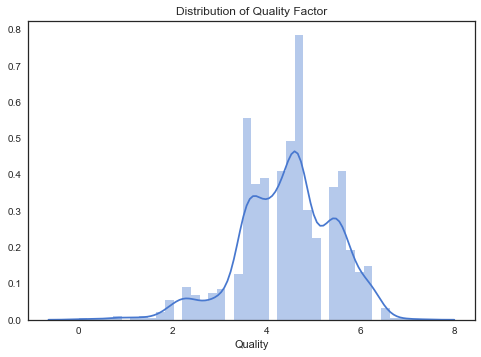

In [127]:
sns.set(color_codes=True)
sns.set(style="white", palette="muted")
plt.title('Distribution of Quality Factor')

sns.distplot(all_['Quality'])

Hmm. Not exactly normal, but it should work for machine learning anyway.

### Just an idea...

I read a paper about how things sell for more when they are in season or even when the weather changes. For example, convertibles sell betterin the spring and summer than in the winter. So I'm going to interact the pool variable and month.

In [128]:
all_['Hotstate1'] = all_['MoSold']*all_['PoolQC']
all_['Hotstate2'] = all_['MoSold']*np.log1p(all_['PoolArea'])

### Getting dummy categorical features

I also still need to get dummies from categorical features.

In [129]:
all_ = pd.get_dummies(all_)
print(all_.shape)

(2919, 281)


Now I split the data back into training and testing sets.

In [130]:
train = all_[:ntrain]
test = all_[ntrain:]

In [131]:
train.shape

(1460, 281)

In [132]:
test.shape

(1459, 281)

Everything seems to be OK.

In [133]:
os.chdir('C:\Users\iriley\Documents\588-econometrics')

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-133-6f5ae683d039>, line 1)

In [134]:
train.to_csv('train2.csv',index=False)
test.to_csv('test2.csv',index=False)